# Cat / Dog Classifier Example

## Initializing the fastbook libraries

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering the data

set the key name AZURE_SEARCH_KEY in the os environmental variables:

In [3]:
#hide
key = os.environ.get('AZURE_SEARCH_KEY', 'f64517777948420785071a6350006d7d')

once you set the key you can simply search bing images by using

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'cat')
ims = results.attrgot('content_url')
len(ims)

150

set the destination where to download the data

In [6]:
animal_types = 'cat', 'dog'
path = Path('cat_or_dog')

In [7]:
if not path.exists():
    path.mkdir()
    for o in animal_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns
len(fns)

267

In [9]:
failed = verify_images(fns)

In [10]:
len(failed)

0

In [11]:
failed

(#0) []

In [12]:
failed.map(Path.unlink)

(#0) []

## From Data to DataLoaders

DataLoaders is a class that makes data available as train and valid data

To stell FastAI to turn data into DataLoader object we need ot tell fastai about the data, how to get the list of items (get_items), how to lable the items (get_y) and how to create the validation set (splitter)

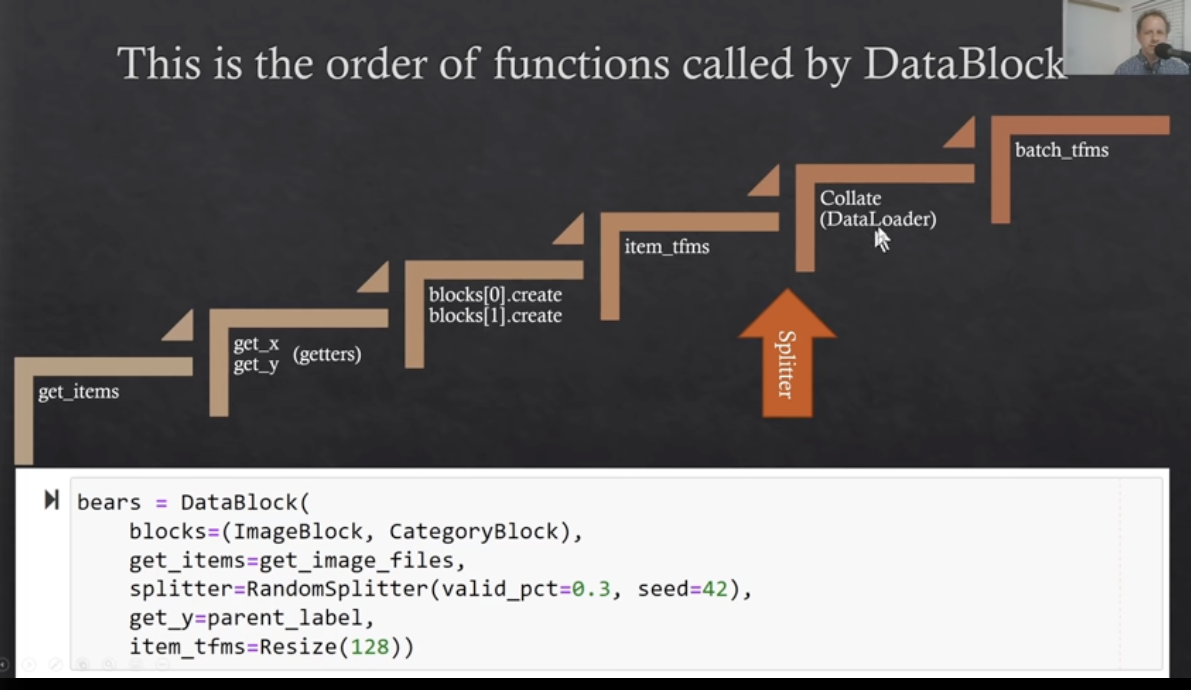

In [13]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

`blocks=(ImageBlock, CategoryBlock)` = (independent / dependent) variables
our independent variables are images, depend are the categories
`parent_label` is looking in the file path at the parent label (grizzli, black, teddy)

`bears` is now a DataBlock object, which allows us to create `DataLoaders`

In [14]:
dls = db.dataloaders(path)

dls is now a dataloaders object, which includes valid and train DataLoaders
DataLoader is a class that provides batches of few items (e.g. 64) to the GPU, all stacked up into a single Tensor(multidimensional array)

We an look at items in a batch of for example the validation data by calling show_batch

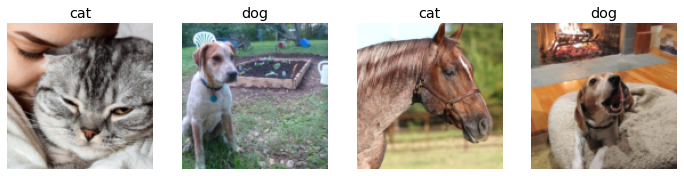

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

We can train the neural net on cropped or padded images
usually the best approach for images is to select different parts of the image and train the NN on that.
So instead of `Resize`, you shuold use the `RandomResizedCrop` function

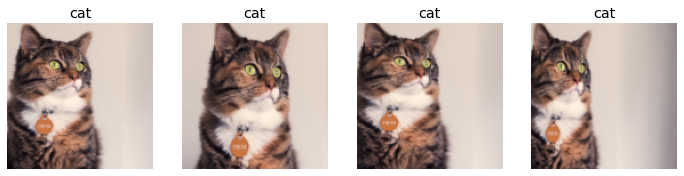

In [16]:
db = db.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = db.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We are using `unique=True` to have the same image repeated with different unique versions of the image

## Data Augmentation
Examples of data augentation are changing the angle, flipping cropping, rotation, warping, changes in brightness and contrast

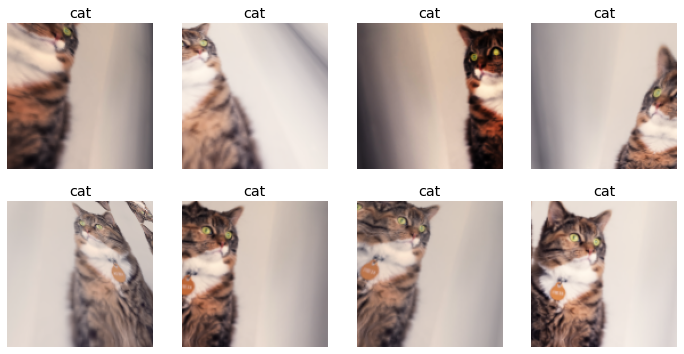

In [17]:
db = db.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = db.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training the model

As we don't have a lot of data (max 150 images), we'll train our model using RandomResizeCrop and aug_transforms

In [18]:
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = db.dataloaders(path)

Use `RandomResizeCrop` to avoid overfitting, since the algorithm is not seeing the same image on each epoch. 
It is an `item_tfms` item transform, so it runs on each item (image).
`min_scale=.5` means we are taking at least 50% of the pixels each time (epoch) and we are going to zoom in to that square.

`aug_transforms` is a batch transform augments each image by stretching and rotating etc.
`batch_tfms` happens on the whole batch and since it is happening on the GPU it does it super fast.

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.970559,0.499847,0.188679,00:09


/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.324094,0.260042,0.075472,00:07
1,0.254109,0.259269,0.037736,00:08
2,0.185924,0.286835,0.037736,00:06
3,0.144034,0.281926,0.037736,00:06


/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


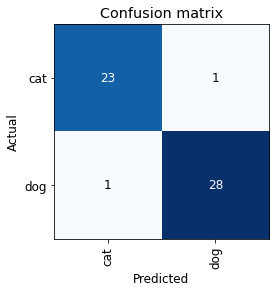

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion metric is calculated using the vaidation set. Any items that are not in the diagonal are false positives.

In order to see where the model is not confident abou it's answers, let's look at the top losses:

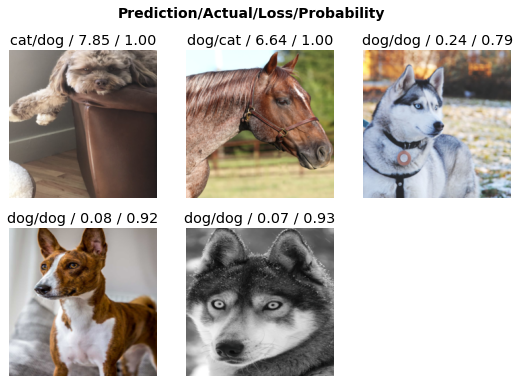

In [21]:
interp.plot_top_losses(5)

In [22]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/ec2-user/SageMaker/.env/fastai/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


We can clean our model by using the line below, see also book:
`cleaner = ImageClassifierCleaner(learn)`

## Exporting our model and using it for Inference

Our model now consistes of two parts
* the architecture of the model (resnet18)
* the trained parameters of the model (bear data)

We can export the model using `learn.export()`

In [23]:
learn.export()

this will write the file `export.pkl`

## Let's use our exported pickle file (model)

In [24]:
learn_inf = load_learner('export.pkl')

In [25]:
learn_inf.predict('images/cat.jpeg')

('cat', tensor(0), tensor([1.0000e+00, 4.3155e-06]))

In [26]:
learn_inf.predict('bears/teddy/00000011.jpg')

('cat', tensor(0), tensor([0.9933, 0.0067]))

to show the list of categories you can use:

In [27]:
learn_inf.dls.vocab

['cat', 'dog']

what does this mean:

('cat', tensor(0), tensor([1.0000e+00, 1.1458e-06]))

This means that the model is very confident that it is a cat (1) and not very confident (1.1 e-06) that it is a dog. The tensors are listed in order by the index of the category.


## How to create a Notebook App from the Inference Model

In [28]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [30]:
img = PILImage.create(btn_upload.data[-1])

In [31]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
pred,pred_idx,probs = learn_inf.predict(img)

In [33]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dog; Probability: 0.7929')

In [34]:
#hide_output
from fastbook import *
from fastai.vision.widgets import *
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [35]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
import ipywidgets as widgets
widgets.__version__
# widgets.IntSlider()

'7.6.3'

In [39]:
!conda list | grep widgets

ipywidgets                7.5.1              pyh9f0ad1d_1    conda-forge
widgetsnbextension        3.5.1            py36h5fab9bb_4    conda-forge
